<a href="https://colab.research.google.com/github/J1116/physics/blob/main/VQE220929_ver6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 各種ライブラリがインストールされていない場合は実行してください
## Google Colaboratory上で実行する場合'You must restart the runtime in order to use newly installed versions.'と出ますが無視してください。
## runtimeを再開するとクラッシュします。
!pip install qulacs pyscf openfermion openfermionpyscf

## Google Colaboratory / (Linux or Mac)のjupyter notebook 環境の場合にのみ実行してください。
## Qulacsのエラーが正常に出力されるようになります。
!pip3 install wurlitzer
%load_ext wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 703 kB 13.0 MB/s 
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 64.0 MB/s 
     |████████████████████████████████| 576 kB 26.6 MB/s 
     |████████████████████████████████| 1.8 MB 65.4 MB/s 
     |████████████████████████████████| 47 kB 4.3 MB/s 
     |████████████████████████████████| 1.0 MB 66.5 MB/s 
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13834 sha256=1ad86af4036c9e071adae5892ff126f9d136fdc19581bf6161c8cea608f0607f
  Stored in directory: /root/.cache/pip/wheels/7c/3d/8c/8192697412e9899dc55bbbb08bbc1197bef333caaa2a71c448
Successfully built pubchempy
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from utility import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import time
import random
import seaborn as sn
from scipy.linalg import expm
from cmath import pi
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs import Observable
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer 
from qulacs.gate import RandomUnitary
from qulacs.state import inner_product

from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算

from scipy.optimize import minimize
import pandas as pd

In [ ]:
class res_VQE():
  def __init__(self, nqubits, depth, VQE_type = "SSVQE", ent_type = "reservoir", n_SS = 2):
    self.nqubits = nqubits
    self.depth = depth
    self.ent_type = ent_type
    # self.state = QuantumState(nqubits)
    # self.state.set_zero_state()
    self.VQE_type = VQE_type
    self.n_SS = n_SS

  def create_obj_H(self, param_obj, H_obj_name = "test1"):
    self.param_obj = param_obj
    if H_obj_name == "test1":
      B = self.param_obj["B"]
      self.Ham = self.H_obj_test1(self.nqubits, B)
    elif H_obj_name == "test2":
      B = self.param_obj["B"]
      self.Ham = self.H_obj_test2(self.nqubits, B)

  def create_res_H(self, delta_t, param_res, H_res_name = "test1"):
    self.param_res = param_res
    self.delta_t = delta_t
    if H_res_name == "test1":
      h = self.param_res["h"]
      D = self.param_res["D"]
      self.Ham_R = self.H_res_test1(self.nqubits, h, D)
    elif H_res_name == "test2":
      h = self.param_res["h"]
      D = self.param_res["D"]
      self.Ham_R = self.H_res_test2(self.nqubits, h, D)
    elif H_res_name == "test3":
      h = self.param_res["h"]
      D = self.param_res["D"]
      self.Ham_R = self.H_res_test3(self.nqubits, h, D)
    elif H_res_name == "test4":
      h = self.param_res["h"]
      D = self.param_res["D"]
      self.Ham_R = self.H_res_test4(self.nqubits, h, D)
  
  def create_circuit(self, theta_list):
    self.circuit = QuantumCircuit(self.nqubits)
    if self.ent_type == "reservoir":
      for d in range(self.depth):
        # 変分量子回路
        for i in range(self.nqubits):
            # circuit.add_gate(merge(RX(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
          self.circuit.add_gate(RX(i, theta_list[2*i+2*self.nqubits*d]))
          self.circuit.add_gate(RZ(i, theta_list[2*i+1+2*self.nqubits*d]))
        # entangler(リザバーハミルトニアンによる時間発展)
        self.circuit.add_observable_rotation_gate(self.Ham_R,self.delta_t,1)
      for i in range(self.nqubits):
        # circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))
        self.circuit.add_gate(RX(i, theta_list[2*i+2*self.nqubits*self.depth]))
        self.circuit.add_gate(RZ(i, theta_list[2*i+1+2*self.nqubits*self.depth]))
    elif self.ent_type == "conventional":
      for d in range(self.depth):
        # 変分量子回路
        for i in range(self.nqubits):
            # circuit.add_gate(merge(RX(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
          self.circuit.add_gate(RX(i, theta_list[2*i+2*self.nqubits*d]))
          self.circuit.add_gate(RZ(i, theta_list[2*i+1+2*self.nqubits*d]))
        # entangler(リザバーハミルトニアンによる時間発展)
        for i in range(self.nqubits//2):
            self.circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(self.nqubits//2-1):
            self.circuit.add_gate(CZ(2*i+1, 2*i+2))
      for i in range(self.nqubits):
        # circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))
        self.circuit.add_gate(RX(i, theta_list[2*i+2*self.nqubits*self.depth]))
        self.circuit.add_gate(RZ(i, theta_list[2*i+1+2*self.nqubits*self.depth]))
    elif self.ent_type == "naive":
      self.circuit.add_observable_rotation_gate(self.Ham_R,self.delta_t,1)
      for i in range(self.nqubits):
        self.circuit.add_gate(RX(i, theta_list[2*i]))
        self.circuit.add_gate(RZ(i, theta_list[2*i+1]))
    # 最後に変分回路作るなら
    
  def cost(self, theta_list):
      self.theta_list = theta_list
      if self.VQE_type == "VQE":
        self.state = QuantumState(self.nqubits)
        self.state.set_zero_state()
        self.create_circuit(theta_list) #量子回路を構成
        self.circuit.update_quantum_state(self.state) #量子回路を状態に作用
        return self.Ham.get_expectation_value(self.state) #ハミルトニアンの期待値を計算
      elif self.VQE_type == "SSVQE":
        exp_val = 0
        self.state = []
        self.create_circuit(theta_list) #量子回路を構成
        for i in range(self.n_SS):
          self.state.append(QuantumState(self.nqubits))
          self.state[i].set_computational_basis(i)
          self.circuit.update_quantum_state(self.state[i]) #量子回路を状態に作用
          exp_val += (0.5 ** i) * self.Ham.get_expectation_value(self.state[i]) #ハミルトニアンの期待値を計算
        return exp_val

    
  def optimize(self, options = {"disp": True, "maxiter": 50, "gtol": 1e-6}):
      self.cost_history = []
      self.options = options
      init_theta_list = np.random.random(2*self.nqubits*(depth+1))*1e-1
      self.cost_history.append(self.cost(init_theta_list))
      method = "BFGS"
      opt = minimize(self.cost, init_theta_list,
                    method=method,
                    callback=lambda x: self.cost_history.append(self.cost(x)),
                    # options = self.options #パラメータの理解がないので入れなくてもよいかも
                    )
      if self.VQE_type == "SSVQE":
        self.exp_result = []
        for i in range(self.n_SS):
          self.exp_result.append(self.Ham.get_expectation_value(self.state[i]))

  def H_obj_test1(self, nqubits, B):
    Ham=Observable(nqubits)
    J = -1
    for i in range(nqubits-1):
        Ham.add_operator(-J,'Z {0} Z {1}'.format(i,i+1))
    for i in range(nqubits):
        Ham.add_operator(B, 'X {0}'.format(i))
    # show_observable(Ham)
    I=np.array([[1,0],[0,1]])
    Z=np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])
    Ham_matrix1=np.zeros((2**nqubits,2**nqubits))
    for i in range(nqubits-1):
        M=1
        for j in range(nqubits):
            if j==i or j == i+1:
                M=np.kron(M,Z)
            else:
                M=np.kron(M,I)
        Ham_matrix1+=M
    Ham_matrix1*=-J
    Ham_matrix2=np.zeros((2**nqubits,2**nqubits))
    for i in range(nqubits):
        M=1
        for j in range(nqubits):
            if j==i:
                M=np.kron(M,X)
            else:
                M=np.kron(M,I)
        Ham_matrix2+=M
    Ham_matrix2*=B
    Ham_matrix = Ham_matrix1 + Ham_matrix2

    # print(np.amin(Ham_matrix))
    # print(Ham_matrix)
    eig = np.linalg.eig(Ham_matrix)
    self.e = np.sort(eig[0])
    self.p = eig[1]
    # print(f"minimum eigenvalue is {self.e}")
    return Ham

  def H_obj_test2(self, nqubits, B):
      Ham=Observable(nqubits)
      J = -1
      for i in range(nqubits-2):
          Ham.add_operator(-J,'Z {0} Z {1} Z {2}'.format(i,i+1, i+2))
      for i in range(nqubits):
          Ham.add_operator(B, 'X {0}'.format(i))
      # show_observable(Ham)
      I=np.array([[1,0],[0,1]])
      Z=np.array([[1,0],[0,-1]])
      X = np.array([[0,1],[1,0]])
      Ham_matrix1=np.zeros((2**nqubits,2**nqubits))
      for i in range(nqubits-2):
          M=1
          for j in range(nqubits):
              if j==i or j == i+1 or j == i+2:
                  M=np.kron(M,Z)
              else:
                  M=np.kron(M,I)
          Ham_matrix1+=M
      Ham_matrix1*=-J
      Ham_matrix2=np.zeros((2**nqubits,2**nqubits))
      for i in range(nqubits):
          M=1
          for j in range(nqubits):
              if j==i:
                  M=np.kron(M,X)
              else:
                  M=np.kron(M,I)
          Ham_matrix2+=M
      Ham_matrix2*=B
      Ham_matrix = Ham_matrix1 + Ham_matrix2

      # print(np.amin(Ham_matrix))
      # print(Ham_matrix)
      eig = np.linalg.eig(Ham_matrix)
      self.e = np.sort(eig[0])
      self.p = eig[1]
      # print(f"minimum eigenvalue is {self.e}")
      return Ham

  @staticmethod
  def H_res_test1(nqubits, h, D):
    Ham_R=Observable(nqubits)
    jr=1
    J=np.random.uniform(-jr/2,jr/2,(nqubits,nqubits))
    H=h + np.random.uniform(-D,D,nqubits)
    for i in range(nqubits):
        for j in range(i):
            Ham_R.add_operator(J[i][j],'Z {0} Z {1}'.format(i,j))
    for k in range(nqubits):
        Ham_R.add_operator(H[k],'X {0}'.format(k))
    return Ham_R

  @staticmethod
  def H_res_test2(nqubits, h, D):
    Ham_R=Observable(nqubits)
    jr=1
    J=np.random.uniform(-jr/2,jr/2, nqubits-1)
    H=h + np.random.uniform(-D,D,nqubits)
    for i in range(nqubits - 1):
        Ham_R.add_operator(J[i],'Z {0} Z {1}'.format(i,i+1))
    for k in range(nqubits):
        Ham_R.add_operator(H[k],'X {0}'.format(k))
    return Ham_R

  @staticmethod
  def H_res_test3(nqubits, h, D):
      Ham_R=Observable(nqubits)
      jr=1
      J=np.random.uniform(-jr/2,jr/2,nqubits-2)
      H=h + np.random.uniform(-D,D,nqubits)
      for i in range(nqubits - 2):
          Ham_R.add_operator(J[i],'Z {0} Z {1} Z {2}'.format(i,i+1, i+2))
      for k in range(nqubits):
          Ham_R.add_operator(H[k],'X {0}'.format(k))
      return Ham_R

  @staticmethod
  def H_res_test4(nqubits, h, D):
    Ham_R=Observable(nqubits)
    jr=1
    J=1
    H=h
    for i in range(nqubits - 1):
        Ham_R.add_operator(J,'Z {0} Z {1}'.format(i,i+1))
    for k in range(nqubits):
        Ham_R.add_operator(H,'X {0}'.format(k))
    return Ham_R


In [ ]:
nqubits=10 #量子ビット数
depth = 2 # gateの深さ
options = {"disp": True, "maxiter": 50, "gtol": 1e-5} # optimizeのoption
B = 0.9 #横磁場の値
delta_t = 6
h = 1
D = 1
param_obj = dict(B = 1.5)
param_res = dict(h = 1, D = 1)

In [ ]:
VQE_type = "SSVQE"
n_SS = 2
ent_type = "reservoir"
model = res_VQE(nqubits, depth, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H(param_obj, H_obj_name = "test1")
model.create_res_H(delta_t, param_res, H_res_name = "test2")
model.optimize(options)
print(f"conversion E0 is {model.exp_result[0]}")
print(f"conversion E1 is {model.exp_result[1]}")
print(f"minimum eigenvalue is {model.e[:2]}")
# print(f"conversion E2 is {model.exp_result[2]}")
ent_type = "conventional"
model = res_VQE(nqubits, depth, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H(param_obj, H_obj_name = "test1")
model.create_res_H(delta_t, param_res, H_res_name = "test2")
model.optimize(options)
print(f"conversion E0 is {model.exp_result[0]}")
print(f"conversion E1 is {model.exp_result[1]}")
print(f"minimum eigenvalue is {model.e[:2]}")
# print(f"conversion E2 is {model.exp_result[2]}")

conversion E0 is -16.37795153398333
conversion E1 is -14.312412564978384
minimum eigenvalue is [-16.53525495 -15.36801737]
conversion E0 is -16.26223609670407
conversion E1 is -13.4587088703051
minimum eigenvalue is [-16.53525495 -15.36801737]


In [ ]:
VQE_type = "SSVQE"
n_SS = 1
ent_type = "reservoir"
model = res_VQE(nqubits, depth, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H(param_obj, H_obj_name = "test1")
model.create_res_H(delta_t, param_res, H_res_name = "test2")
model.optimize(options)
print(f"conversion E0 is {model.exp_result[0]}")
# print(f"conversion E1 is {model.exp_result[1]}")
print(f"minimum eigenvalue is {model.e[0]}")
# print(f"conversion E2 is {model.exp_result[2]}")
ent_type = "conventional"
model = res_VQE(nqubits, depth, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H(param_obj, H_obj_name = "test1")
model.create_res_H(delta_t, param_res, H_res_name = "test2")
model.optimize(options)
print(f"conversion E0 is {model.exp_result[0]}")
# print(f"conversion E1 is {model.exp_result[1]}")
print(f"minimum eigenvalue is {model.e[0]}")
# print(f"conversion E2 is {model.exp_result[2]}")
ent_type = "naive"
model = res_VQE(nqubits, depth, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H(param_obj, H_obj_name = "test1")
model.create_res_H(delta_t, param_res, H_res_name = "test2")
model.optimize(options)
print(f"conversion E0 is {model.exp_result[0]}")
# print(f"conversion E1 is {model.exp_result[1]}")
print(f"minimum eigenvalue is {model.e[0]}")
# print(f"conversion E2 is {model.exp_result[2]}")

conversion E0 is -16.403620332839957
minimum eigenvalue is -16.535254946759135
conversion E0 is -16.41924660090597
minimum eigenvalue is -16.535254946759135
conversion E0 is -15.370122560852554
minimum eigenvalue is -16.535254946759135


In [ ]:
VQE_type = "VQE"
n_SS = 2
ent_type = "reservoir"
model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H("test1", B)
model.create_res_H(h = h, D = D, H_res_name = "test1")
model.optimize(options)
print(f"minimum eigenvalue is {model.e[0]}")
print(f"conversion E0 is {model.cost_history[-1]}")
# print(f"conversion E1 is {model.exp_result[1]}")
# print(f"conversion E2 is {model.exp_result[2]}")
ent_type = "conventional"
model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H("test1", B)
model.create_res_H(h = h, D = D, H_res_name = "test1")
model.optimize(options)
print(f"minimum eigenvalue is {model.e[0]}")
print(f"conversion E0 is {model.cost_history[-1]}")
# print(f"conversion E0 is {model.exp_result[0]}")
# print(f"conversion E1 is {model.exp_result[1]}")
# print(f"conversion E2 is {model.exp_result[2]}")

minimum eigenvalue is -11.683578778690109
conversion E0 is -11.362435975795334
minimum eigenvalue is -11.683578778690109
conversion E0 is -10.71156694665736


In [ ]:
VQE_type = "VQE"
n_SS = 2
ent_type = "reservoir"
delta_t = [0,6]
model = res_VQE(nqubits, depth, delta_t = delta_t[0], VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H("test1", B)
model.create_res_H(h = h, D = D, H_res_name = "test1")
model.optimize(options)
print(f"minimum eigenvalue is {model.e[0]}")
print(f"conversion E0 is {model.cost_history[-1]}")
# print(f"theta_list : {model.theta_list}")
model = res_VQE(nqubits, depth, delta_t = delta_t[1], VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
model.create_obj_H("test1", B)
model.create_res_H(h = h, D = D, H_res_name = "test1")
model.optimize(options)
print(f"minimum eigenvalue is {model.e[0]}")
print(f"conversion E0 is {model.cost_history[-1]}")
# print(f"theta_list : {model.theta_list}")

In [ ]:
N = 50
h_range = np.linspace(-2,2,50)
error = np.zeros((2,N))
for i in range(N):
  D = 0
  h = 10 ** h_range[i]
  VQE_type = "SSVQE"
  n_SS = 2
  ent_type = "reservoir"
  model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
  model.create_obj_H("test1", B)
  model.create_res_H(h = h, D = D, H_res_name = "test1")
  model.optimize(options)
  error[:,i] = np.abs(model.exp_result - model.e[:2])
  print(f"iteration : {i}")
  print(f"conversion E0 is {model.exp_result[0]}")
  print(f"conversion E1 is {model.exp_result[1]}")
  print(f"minimum eigenvalue is {model.e[:2]}")
  print(f"error is {error[:,i]}")


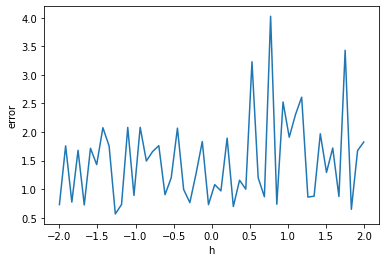

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('h')  # x軸ラベル
ax.set_ylabel('error')  # y軸ラベル
# time=[i/10 for i in range(20)]
ax.plot(h_range, error[0])
# ax.plot(time, error,linestyle='dashed')

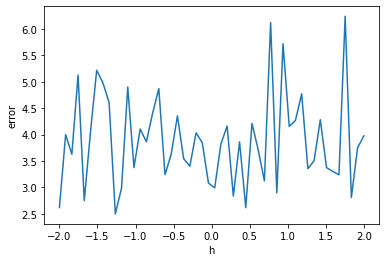

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('h')  # x軸ラベル
ax.set_ylabel('error')  # y軸ラベル
# time=[i/10 for i in range(20)]
ax.plot(h_range, error[1])
# ax.plot(time, error,linestyle='dashed')

In [ ]:
nqubits=10 #量子ビット数
depth = 2 # gateの深さ
options = {"disp": True, "maxiter": 50, "gtol": 1e-5} # optimizeのoption
B = 0.9 #横磁場の値
delta_t = 6
h = 1
D = 1

iteration : 0
iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
iteration : 25
iteration : 26
iteration : 27
iteration : 28
iteration : 29
iteration : 30
iteration : 31
iteration : 32
iteration : 33
iteration : 34
iteration : 35
iteration : 36
iteration : 37
iteration : 38
iteration : 39


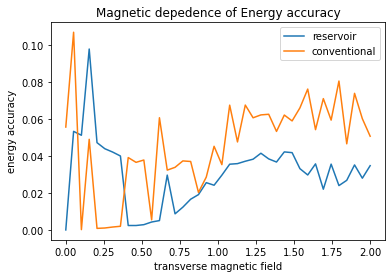

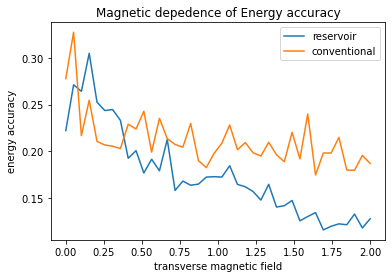

In [ ]:
N = 30
M = 4
B_range = np.linspace(0,2,N)
error_res = np.zeros((2,N,M))
error_conv = np.zeros((2,N,M))
for i in range(N):
    print(f"iteration : {i}")
    B = B_range[i]
    D = 1
    h = 1
    VQE_type = "SSVQE"
    n_SS = 2
    for j in range(M):
        ent_type = "reservoir"
        model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        model.create_obj_H("test1", B)
        model.create_res_H(h = h, D = D, H_res_name = "test2")
        model.optimize(options)
        error_res[:,i,j] = np.abs((model.exp_result - model.e[:2]) / model.e[:2])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")

        ent_type = "conventional"
        model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        model.create_obj_H("test1", B)
        model.create_res_H(h = h, D = D, H_res_name = "test2")
        model.optimize(options)
        error_conv[:,i,j] = np.abs((model.exp_result - model.e[:2]) / model.e[:2])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")
error_res2 = np.mean(error_res, axis = 2)
error_conv2 = np.mean(error_conv, axis = 2)

plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2[0], "-", label="reservoir")
plt.plot(B_range, error_conv2[0], "-", label="conventional")
plt.legend()
plt.show()

plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2[1], "-", label="reservoir")
plt.plot(B_range, error_conv2[1], "-", label="conventional")
plt.legend()
plt.show()

In [ ]:
error_res2 = np.mean(error_res, axis = 2)
error_conv2 = np.mean(error_conv, axis = 2)

In [ ]:
error_conv2

array([[7.44124207e-12, 1.25669697e-02, 5.68698515e-02, 4.98472396e-02,
        3.17972783e-02],
       [5.00000000e-01, 4.20216003e-01, 3.84485935e-01, 4.15481069e-01,
        3.13970837e-01]])

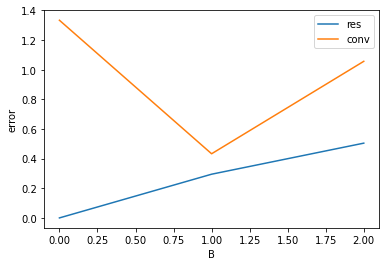

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('B')  # x軸ラベル
ax.set_ylabel('error')  # y軸ラベル
# time=[i/10 for i in range(20)]
ax.plot(B_range, error_res2[0,:], label = "res")
ax.plot(B_range, error_conv2[0,:], label = "conv")
ax.legend(loc = 'upper right') 
# ax.plot(time, error,linestyle='dashed')

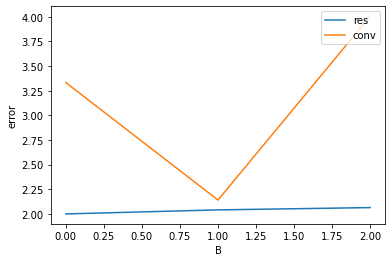

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('B')  # x軸ラベル
ax.set_ylabel('error')  # y軸ラベル
# time=[i/10 for i in range(20)]
ax.plot(B_range, error_res2[1,:], label = "res")
ax.plot(B_range, error_conv2[1,:], label = "conv")
ax.legend(loc = 'upper right')
# ax.plot(time, error,linestyle='dashed')

In [ ]:
error_res

array([[[1.17404415e-01, 1.44728673e-11, 1.28581932e-01],
        [1.71173316e-02, 1.00724184e-02, 1.08076739e-02],
        [1.48487080e-01, 1.24065563e-01, 8.47559846e-02],
        [1.92556509e-01, 1.78499923e-01, 4.51919854e-02],
        [1.75590468e-01, 5.97827389e-02, 1.83290951e-01],
        [2.37150234e-01, 1.83818468e-01, 4.18125835e-01],
        [1.49914257e-01, 1.86352513e-01, 7.26963907e-01],
        [4.06904639e-01, 3.93102785e-01, 6.00278084e-01],
        [8.73355682e-01, 2.70099636e-01, 4.51234383e-01],
        [1.34780205e-01, 1.62171110e-01, 3.27834946e-01],
        [1.77113636e-01, 3.76991655e-01, 3.54535340e-01]],

       [[1.58692942e-01, 2.00000000e+00, 6.07783300e-01],
        [1.77470484e+00, 1.94989064e+00, 1.91058486e+00],
        [4.11621611e-01, 6.04613206e-01, 9.79544083e-01],
        [1.02804993e+00, 1.65829615e+00, 4.73016983e-01],
        [3.73248337e-01, 8.16583139e-01, 9.09032297e-01],
        [9.55841565e-01, 8.40094962e-01, 8.71687011e-01],
        [1.0

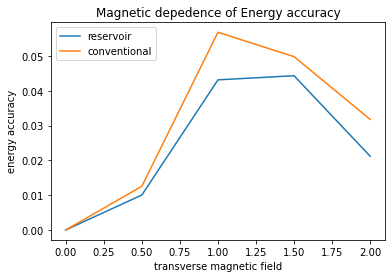

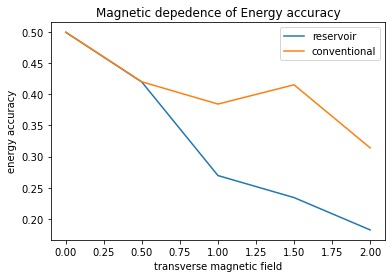

In [ ]:
plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2[0], "-", label="reservoir")
plt.plot(B_range, error_conv2[0], "-", label="conventional")
plt.legend()
plt.show()

plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2[1], "-", label="reservoir")
plt.plot(B_range, error_conv2[1], "-", label="conventional")
plt.legend()
plt.show()

In [ ]:
nqubits=10 #量子ビット数
depth = 2 # gateの深さ
options = {"disp": True, "maxiter": 50, "gtol": 1e-5} # optimizeのoption
B = 0.9 #横磁場の値
delta_t = 6
h = 1
D = 1

In [ ]:
N = 30
M = 3
B_range = np.linspace(0,2,N)
error_res = np.zeros((2,N,M))
error_conv = np.zeros((2,N,M))
for i in range(N):
    print(f"iteration : {i}")
    B = B_range[i]
    D = 1
    h = 1
    VQE_type = "SSVQE"
    n_SS = 2
    for j in range(M):
        ent_type = "reservoir"
        model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        model.create_obj_H("test2", B)
        model.create_res_H(h = h, D = D, H_res_name = "test3")
        model.optimize(options)
        error_res[:,i,j] = np.abs((model.exp_result - model.e[:2]) / model.e[:2])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")

        ent_type = "conventional"
        model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        model.create_obj_H("test2", B)
        model.create_res_H(h = h, D = D, H_res_name = "test3")
        model.optimize(options)
        error_conv[:,i,j] = np.abs((model.exp_result - model.e[:2]) / model.e[:2])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")
error_res2 = np.mean(error_res, axis = 1)
error_res_var = np.std(error_res, axis = 1)
error_conv2 = np.mean(error_conv, axis = 1)
error_conv_var = np.std(error_conv, axis = 1)

plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2[0], "-", label="reservoir")
plt.plot(B_range, error_conv2[0], "-", label="conventional")
plt.legend()
plt.show()

plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2[1], "-", label="reservoir")
plt.plot(B_range, error_conv2[1], "-", label="conventional")
plt.legend()
plt.show()

iteration : 0
iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10


KeyboardInterrupt: ignored

iteration : 0
iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
iteration : 25
iteration : 26
iteration : 27
iteration : 28
iteration : 29


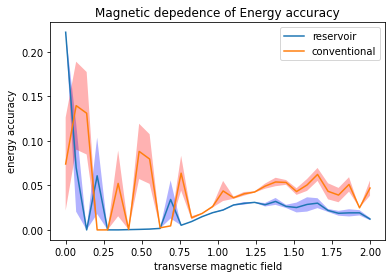

In [ ]:
N = 30
M = 3
B_range = np.linspace(0,2,N)
error_res = np.zeros((N,M))
error_conv = np.zeros((N,M))
for i in range(N):
    print(f"iteration : {i}")
    B = B_range[i]
    D = 1
    h = 1
    VQE_type = "VQE"
    n_SS = 2
    for j in range(M):
        ent_type = "reservoir"
        model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        model.create_obj_H("test1", B)
        model.create_res_H(h = h, D = D, H_res_name = "test2")
        model.optimize(options)
        error_res[i,j] = np.abs((model.cost_history[-1] - model.e[0]) / model.e[0])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")

        ent_type = "conventional"
        model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        model.create_obj_H("test1", B)
        model.create_res_H(h = h, D = D, H_res_name = "test2")
        model.optimize(options)
        error_conv[i,j] = np.abs((model.cost_history[-1] - model.e[0]) / model.e[0])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")
error_res2 = np.mean(error_res, axis = 1)
error_res_var = np.std(error_res, axis = 1)
error_conv2 = np.mean(error_conv, axis = 1)
error_conv_var = np.std(error_conv, axis = 1)

plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2, "-", label="reservoir")
plt.fill_between(B_range, error_res2 - error_res_var/2, error_res2 + error_res_var/2, facecolor='blue', alpha=0.3)
plt.plot(B_range, error_conv2, "-", label="conventional")
plt.fill_between(B_range, error_conv2 - error_conv_var/2, error_conv2 + error_conv_var/2, facecolor='red', alpha=0.3)
plt.legend()
plt.show()

# plt.xlabel("transverse magnetic field")
# plt.ylabel("energy accuracy")
# plt.title("Magnetic depedence of Energy accuracy")
# plt.plot(B_range, error_res2[1], "-", label="reservoir")
# plt.plot(B_range, error_conv2[1], "-", label="conventional")
# plt.legend()
# plt.show()

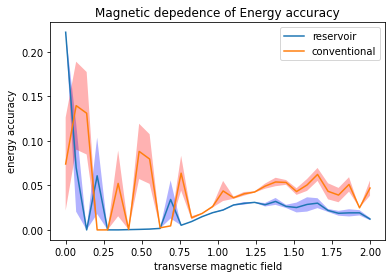

In [ ]:
plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2, "-", label="reservoir")
plt.fill_between(B_range, error_res2 - error_res_var/2, error_res2 + error_res_var/2, facecolor='blue', alpha=0.3)
plt.plot(B_range, error_conv2, "-", label="conventional")
plt.fill_between(B_range, error_conv2 - error_conv_var/2, error_conv2 + error_conv_var/2, facecolor='red', alpha=0.3)
plt.legend()
plt.savefig("adjacent_var.png", format="png", dpi=300)
plt.show()

In [ ]:
nqubits=10 #量子ビット数
depth = 2 # gateの深さ
options = {"disp": True, "maxiter": 50, "gtol": 1e-5} # optimizeのoption
B = 1.5 #横磁場の値
delta_t = 6
h = 1
D = 1

iteration : 0
iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
iteration : 25
iteration : 26
iteration : 27
iteration : 28
iteration : 29
iteration : 30
iteration : 31
iteration : 32
iteration : 33
iteration : 34
iteration : 35
iteration : 36
iteration : 37
iteration : 38
iteration : 39
iteration : 40
iteration : 41
iteration : 42
iteration : 43
iteration : 44
iteration : 45
iteration : 46
iteration : 47
iteration : 48
iteration : 49
iteration : 50
iteration : 51
iteration : 52
iteration : 53
iteration : 54
iteration : 55
iteration : 56
iteration : 57
iteration : 58
iteration : 59
iteration : 60
iteration : 61
iteration : 62
iteration : 63
iteration : 64
iteration : 65
iteration : 66
itera

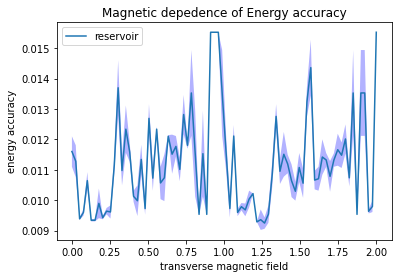

In [ ]:
N = 80
M = 3
B_range = np.linspace(0,2,N)
error_res = np.zeros((N,M))
error_conv = np.zeros((N,M))
for i in range(N):
    print(f"iteration : {i}")
    B = 1.5
    D = 1
    h = B_range[i]
    VQE_type = "VQE"
    n_SS = 2
    for j in range(M):
        ent_type = "reservoir"
        model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        model.create_obj_H("test1", B)
        model.create_res_H(h = h, D = D, H_res_name = "test4")
        model.optimize(options)
        error_res[i,j] = np.abs((model.cost_history[-1] - model.e[0]) / model.e[0])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")

        # ent_type = "conventional"
        # model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        # model.create_obj_H("test1", B)
        # model.create_res_H(h = h, D = D, H_res_name = "test2")
        # model.optimize(options)
        # error_conv[i,j] = np.abs((model.cost_history[-1] - model.e[0]) / model.e[0])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")
error_res2 = np.mean(error_res, axis = 1)
error_res_var = np.std(error_res, axis = 1)
# error_conv2 = np.mean(error_conv, axis = 1)
# error_conv_var = np.std(error_conv, axis = 1)

plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2, "-", label="reservoir")
plt.fill_between(B_range, error_res2 - error_res_var/2, error_res2 + error_res_var/2, facecolor='blue', alpha=0.3)
# plt.plot(B_range, error_conv2, "-", label="conventional")
# plt.fill_between(B_range, error_conv2 - error_conv_var/2, error_conv2 + error_conv_var/2, facecolor='red', alpha=0.3)
plt.legend()
plt.show()

# plt.xlabel("transverse magnetic field")
# plt.ylabel("energy accuracy")
# plt.title("Magnetic depedence of Energy accuracy")
# plt.plot(B_range, error_res2[1], "-", label="reservoir")
# plt.plot(B_range, error_conv2[1], "-", label="conventional")
# plt.legend()
# plt.show()

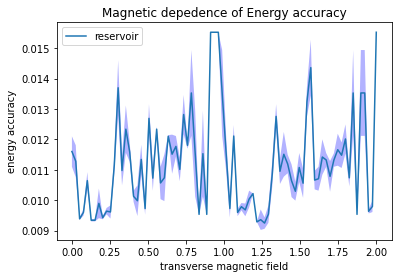

In [ ]:
plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(B_range, error_res2, "-", label="reservoir")
plt.fill_between(B_range, error_res2 - error_res_var/2, error_res2 + error_res_var/2, facecolor='blue', alpha=0.3)
# plt.plot(B_range, error_conv2, "-", label="conventional")
# plt.fill_between(B_range, error_conv2 - error_conv_var/2, error_conv2 + error_conv_var/2, facecolor='red', alpha=0.3)
plt.legend()
plt.savefig("phase2_var.png", format="png", dpi=300)
plt.show()

iteration : 0
iteration : 1
iteration : 2
iteration : 3
iteration : 4
iteration : 5
iteration : 6
iteration : 7
iteration : 8
iteration : 9
iteration : 10
iteration : 11
iteration : 12
iteration : 13
iteration : 14
iteration : 15
iteration : 16
iteration : 17
iteration : 18
iteration : 19
iteration : 20
iteration : 21
iteration : 22
iteration : 23
iteration : 24
iteration : 25
iteration : 26
iteration : 27
iteration : 28
iteration : 29
iteration : 30
iteration : 31
iteration : 32
iteration : 33
iteration : 34
iteration : 35
iteration : 36
iteration : 37
iteration : 38
iteration : 39


NameError: ignored

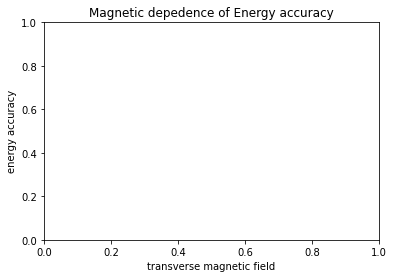

In [ ]:
N = 40
M = 3
param_range = np.linspace(0,10,N)
error_res = np.zeros((N,M))
error_conv = np.zeros((N,M))
param_obj = dict(B = 1.5)
param_res = dict(h = 1, D = 1)
ent_type = "naive"
for i in range(N):
    print(f"iteration : {i}")
    # B = 1.5
    # D = 1
    delta_t = param_range[i]
    # h = 1
    VQE_type = "VQE"
    n_SS = 1
    for j in range(M):
        model = res_VQE(nqubits, depth, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        model.create_obj_H(param_obj,"test1")
        model.create_res_H(delta_t, param_res, H_res_name = "test2")
        model.optimize(options)
        error_res[i,j] = np.abs((model.cost_history[-1] - model.e[0]) / model.e[0])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")

        # ent_type = "conventional"
        # model = res_VQE(nqubits, depth, delta_t, VQE_type = VQE_type, ent_type = ent_type, n_SS = n_SS)
        # model.create_obj_H("test1", B)
        # model.create_res_H(h = h, D = D, H_res_name = "test2")
        # model.optimize(options)
        # error_conv[i,j] = np.abs((model.cost_history[-1] - model.e[0]) / model.e[0])
    #     print(f"iteration : {i}")
        # print(f"conversion E0 is {model.exp_result[0]}")
        # print(f"conversion E1 is {model.exp_result[1]}")
        # print(f"minimum eigenvalue is {model.e[:2]}")
        # print(f"error is {error[:,i]}")
error_res2 = np.mean(error_res, axis = 1)
error_res_var = np.std(error_res, axis = 1)
# error_conv2 = np.mean(error_conv, axis = 1)
# error_conv_var = np.std(error_conv, axis = 1)

plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(param_range, error_res2, "-", label="reservoir")
plt.fill_between(param_range, error_res2 - error_res_var/2, error_res2 + error_res_var/2, facecolor='blue', alpha=0.3)
# plt.plot(B_range, error_conv2, "-", label="conventional")
# plt.fill_between(B_range, error_conv2 - error_conv_var/2, error_conv2 + error_conv_var/2, facecolor='red', alpha=0.3)
plt.legend()
plt.show()

# plt.xlabel("transverse magnetic field")
# plt.ylabel("energy accuracy")
# plt.title("Magnetic depedence of Energy accuracy")
# plt.plot(B_range, error_res2[1], "-", label="reservoir")
# plt.plot(B_range, error_conv2[1], "-", label="conventional")
# plt.legend()
# plt.show()

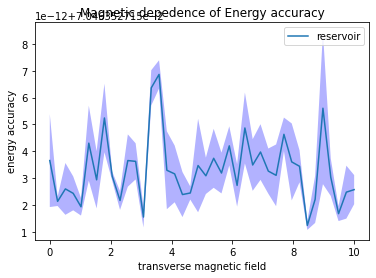

In [ ]:
plt.xlabel("transverse magnetic field")
plt.ylabel("energy accuracy")
plt.title("Magnetic depedence of Energy accuracy")
plt.plot(delta_t_range, error_res2, "-", label="reservoir")
plt.fill_between(delta_t_range, error_res2 - error_res_var/2, error_res2 + error_res_var/2, facecolor='blue', alpha=0.3)
# plt.plot(B_range, error_conv2, "-", label="conventional")
# plt.fill_between(B_range, error_conv2 - error_conv_var/2, error_conv2 + error_conv_var/2, facecolor='red', alpha=0.3)
plt.legend()
# plt.savefig("phase2_var.png", format="png", dpi=300)
plt.show()